# Plot differences between epochs 
#### From files in ./analogue_data/analogue_differences

### Functions

In [42]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from scipy import ndimage
from datetime import datetime, timedelta

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')   # alice
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python')                   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

### Directories

In [43]:
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'

# alice
CERRA_dir = '/media/alice/Crucial X9/portal/data_CNR/CERRA/'
ERA5_dir = '/media/alice/Crucial X9/portal/data_CNR/ERA5/'
CRCM5_dir = '/media/alice/Crucial X9/portal/data_CNR/CRCM5-LE/'
fig_dir = '/home/alice/Desktop/CNR/ENCIRCLE/materiale_alice/figures/analogues/'
diff_dir = './analogue_data/analogue_differences/' 

### Variable

In [44]:
# Variable
var_analogues = 'psl'  # Variable used to find the analogues, e.g. 'psl' for sea level pressure

### Event

In [45]:
# Event
lselect = 'alertregions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 6
no_event = 19
event_origin = 'ERA5'  # 'ERA5' or 'CRCM5-LE'
if event_origin == 'ERA5':
    str_event = f'node{no_node}-extreme{no_event}-{lselect}'
    df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alertregions_CERRA.xlsx', sheet_name=no_node-1)
    time_event = df_events['Time'].iloc[no_event-1] + pd.Timedelta('12h')
elif event_origin == 'CRCM5-LE':
    str_event = f'BAM-node{no_node}-extreme{no_event}-{lselect}'
    BAM_dict, BAM_index = fanPM.get_best_model_analogue_info(no_node, no_event, varname)
    time_event = datetime.strptime(BAM_dict['date'][BAM_index], "%Y-%m-%d")
# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

### Analogue selection

In [46]:
# Quantile
qtl_LE = 0.99

# Number of ensemble members
no_membs = 49
# List of members
list_membs = [name for name in os.listdir(CRCM5_dir + 'psl') if os.path.isdir(os.path.join(CRCM5_dir + 'psl', name))]
list_membs = sorted(list_membs)[:no_membs]  # Select the first 'no_membs' members
print(list_membs)

# Epochs
# list_year_ranges = [[1955, 1974], [2004, 2023], [2080, 2099]] # past [1955-1974], present [2004-2023], near-future [2030-2049], far future [2080-2099]
list_year_ranges = [[1955, 1974], [2004,2023], [2080,2099]]
no_epochs = len(list_year_ranges)

# Difference between epochs
list_diff_indices = [[0,1],[0,2],[1,2]]  # Define the indices of epochs to compare

# Months for analogue selection
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
month_names = [calendar.month_abbr[month] for month in months_sel]
str_months = ''.join([name[0] for name in month_names])

['kba', 'kbb', 'kbc', 'kbd', 'kbe', 'kbf', 'kbg', 'kbh', 'kbi', 'kbj', 'kbk', 'kbl', 'kbm', 'kbn', 'kbo', 'kbp', 'kbq', 'kbr', 'kbs', 'kbt', 'kbu', 'kbv', 'kbw', 'kbx', 'kby', 'kbz', 'kca', 'kcb', 'kcc', 'kcd', 'kce', 'kcf', 'kcg', 'kch', 'kci', 'kcj', 'kck', 'kcl', 'kcm', 'kcn', 'kco', 'kcp', 'kcq', 'kcr', 'kcs', 'kct', 'kcu', 'kcw', 'kcx']


### Upload Euclidean distance of analogues from event

In [47]:
# Load ensemble data
ensemble_data = []
for i, year_range in enumerate(list_year_ranges):
    epoch_data = {}
    for memb in list_membs:
        # Construct the file path
        file_path = f'./analogue_data/times_distances_analogues-{var_analogues}_{str_event}_{int(qtl_LE*100)}pct_{year_range[0]}-{year_range[1]}_CRCM5-LE_memb-{memb}.npz'
        # Load the data from the npz file
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        # Load the data
        data = np.load(file_path, allow_pickle=True)
        times = data['times']
        distances = data['distances']
        epoch_data[memb] = {'times': times, 'distances': distances}
    ensemble_data.append(epoch_data)
no_analogues_LE = len(ensemble_data[0][list_membs[0]]['times'])  # Number of analogues per member

# Load ERA5 data
file_path_ERA5 = f'./analogue_data/times_distances_analogues-mslp_node{no_node}-extreme{no_event}-alertregions_{int(qtl_LE*100)}pct_2004-2023_ERA5.npz'
if not os.path.exists(file_path_ERA5):
    print(f"File not found: {file_path_ERA5}")
# Load the data
data_ERA5 = np.load(file_path_ERA5, allow_pickle=True)

In [48]:
# Distance from event
# CRCM5-LE distances
list_distances = []  # Initialize distances array for plotting
list_times = []  # Initialize times array
mean_dist = np.zeros(no_epochs)  # Initialize mean distance array for plotting
for i in range(len(list_year_ranges)):
    distances = np.zeros((no_membs, no_analogues_LE))  # Initialize distances array for plotting
    times = []  # Initialize times array for plotting
    for im, memb in enumerate(list_membs):
        # Extract distances for the current member and epoch
        distances[im] = ensemble_data[i][memb]['distances']
        times.append(ensemble_data[i][memb]['times'])
    list_distances.append(distances)  # Append distances for the current epoch
    mean_dist[i] = np.mean(distances)  # Calculate mean distance for the current epoch
    list_times.append(times)  # Append times for the current epoch

# ERA5 distances
distances_ERA5 = data_ERA5['distances']

### Plot distance from event in the different epochs

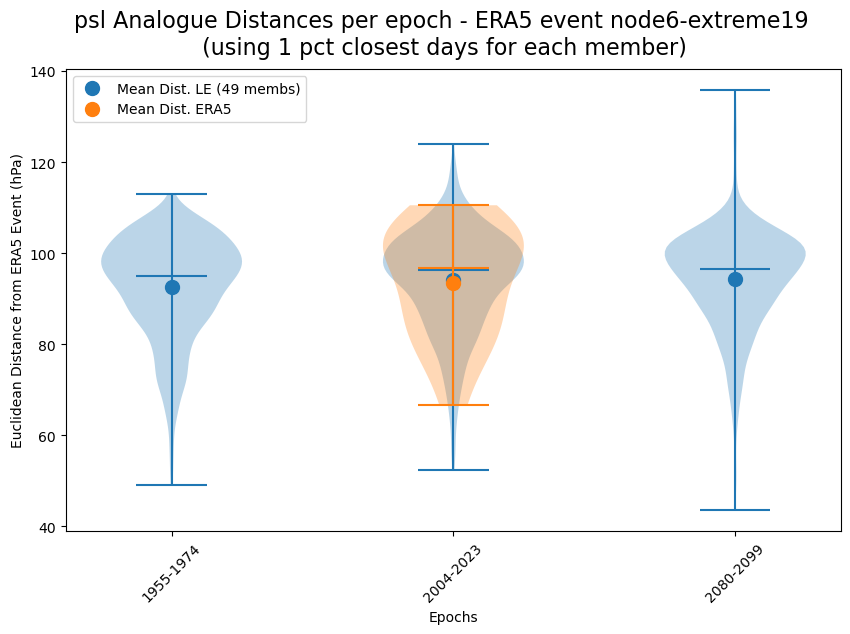

In [49]:

# Plot distance from event in the different epochs
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
if event_origin == 'ERA5':
    fig.suptitle(f"{var_analogues} Analogue Distances per epoch - ERA5 event node{no_node}-extreme{no_event}\n (using {100-int(100*qtl_LE)} pct closest days for each member)", fontsize=16) 
elif event_origin == 'CRCM5-LE':
    fig.suptitle(f"{var_analogues} Analogue Distances per epoch - CRCM5-LE BAM node{no_node}-extreme{no_event}\n (using {100-int(100*qtl_LE)} pct closest days for each member)", fontsize=16)

# Violin plot setup
list_epoch_str = [f"{year_range[0]}-{year_range[1]}" for year_range in list_year_ranges]
# # Plot violin per member
# for im in range(no_membs):
#     dist_per_epoch = [dist_epoch[im] for dist_epoch in list_distances]
#     vp = ax.violinplot(dist_per_epoch, showmeans=False, showmedians=True, showextrema=True)
#     median_color = vp['cmedians'].get_color() 
# Plot violin per epoch
dist_per_epoch = [dist_epoch.flatten() for dist_epoch in list_distances]
vp = ax.violinplot(dist_per_epoch, showmeans=False, showmedians=True, showextrema=True)
median_color = vp['cmedians'].get_color() 
# Plot violin per epoch
# Plot the mean distance for the epoch
ax.plot(np.arange(1,no_epochs+1), mean_dist, marker='o', color=median_color, markersize=10, label=f'Mean Dist. LE ({no_membs} membs)', linewidth=0)

if event_origin == 'ERA5':
    # Plot ERA5 violin
    vp = ax.violinplot(distances_ERA5, positions=[2], showmeans=False, showmedians=True, showextrema=True)
    median_color = vp['cmedians'].get_color() 
    # Plot the mean distance
    ax.plot(2, distances_ERA5.mean(), marker='o', color=median_color, markersize=10, label=f'Mean Dist. ERA5', linewidth=0)

# Ticks and labels
ax.set_xticks(range(1, no_epochs+1))
ax.set_xticklabels(list_epoch_str, rotation=45)
ax.set_xlabel('Epochs')
if event_origin == 'ERA5':
    ax.set_ylabel('Euclidean Distance from ERA5 Event (hPa)')
elif event_origin == 'CRCM5-LE':
    ax.set_ylabel('Euclidean Distance from BAM Event (hPa)')
ax.legend()

# Save the figure
fig.savefig(f"{fig_dir}analogue-distances-{var_analogues}_{str_event}_{int(qtl_LE*100)}pct_CRCM5_{no_membs}membs.png", bbox_inches='tight', dpi=300)    


In [50]:
# Show distances member by member when at least one distance is below 40 and above 120
for i_ep in range(no_epochs):
    print("Epoch ",i_ep)
    for im in range(no_membs):
        if np.any(list_distances[i_ep][im] < 50) or np.any(list_distances[i_ep][im] > 120):
            print(f"Member {list_membs[im]}")
            print(f"Distances: {list_distances[i_ep][im]}")
            print(f"Timesteps: {list_times[i_ep][im]}")

Epoch  0
Member kcf
Distances: [ 48.97783661  81.13903809  82.19802094  82.21157837  82.74019623
  84.35597229  90.36619568  94.29099274  95.86791992  96.33217621
  98.31375885  98.32874298  98.79550171 100.02478027 100.12741089
 100.2206192  102.47193146 103.72541809]
Timesteps: [cftime.DatetimeNoLeap(1971, 9, 20, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1966, 11, 22, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1957, 10, 13, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1972, 10, 8, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1973, 10, 7, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1962, 10, 6, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1957, 9, 12, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1959, 9, 29, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1960, 9, 13, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1968, 10, 1, 0, 0, 0, 0, has_year_zero=True)
 cftime.DatetimeNoLeap(1961, 10, 7, 0

Con ncview confronta clim Epoch 2 di kby e kbg (struttura jet ecc molto diversa)

### Best analogue in model

In [51]:
# Best analogue in model overall
ind_member = np.where(list_distances[1]==np.min(list_distances[1]))[0][0]
no_BAM = np.where(list_distances[1]==np.min(list_distances[1]))[1][0]
print('Member and no-analogue:',list_membs[ind_member], no_BAM)  # Example usage of np.argmin to find the index of the minimum distance in the first epoch for the first member
print('Euclidean distance: ', ensemble_data[1][list_membs[ind_member]]['distances'][0])  # Print the shape of the distances array for the first epoch
print('Date:', ensemble_data[1][list_membs[ind_member]]['times'][0])

Member and no-analogue: kcb 0
Euclidean distance:  52.37375
Date: 2006-11-24 00:00:00


In [52]:
# Best analogues in model
N_BAM = 10  # Number of best analogues to find
flat_indices = np.argsort(list_distances[1], axis=None)
indices_minima = np.unravel_index(flat_indices, list_distances[1].shape)
ind_members = indices_minima[0][:N_BAM]
list_BAM_members = [list_membs[i] for i in ind_members]
ind_extremes = indices_minima[1][:N_BAM]
list_BAM_dates_noleap = [ensemble_data[1][list_BAM_members[ii]]['times'][ind_extremes[ii]] for ii in range(len(list_BAM_members))]
print('Members and no-analogues:', list_BAM_members, ind_extremes)
print('Euclidean distances:', [ensemble_data[1][list_BAM_members[ii]]['distances'][ind_extremes[ii]] for ii in range(len(list_BAM_members))])
print('Dates:', [d.strftime("%Y-%m-%d") for d in list_BAM_dates_noleap])

Members and no-analogues: ['kcb', 'kbn', 'kcd', 'kby', 'kbm', 'kbh', 'kbg', 'kbe', 'kbx', 'kbf'] [0 0 0 0 0 0 0 0 0 0]
Euclidean distances: [np.float32(52.37375), np.float32(52.754066), np.float32(55.0041), np.float32(56.167362), np.float32(56.437897), np.float32(57.320843), np.float32(57.566547), np.float32(57.841354), np.float32(60.127438), np.float32(60.790497)]
Dates: ['2006-11-24', '2012-09-26', '2021-11-22', '2014-10-26', '2015-10-28', '2019-11-09', '2005-10-31', '2007-11-11', '2016-10-07', '2017-09-24']


### Plot precipitation ERA5 event (if event_origin is ERA5) 

In [53]:
# event time
# ERA5
df_events = pd.read_excel(CERRA_dir+'events_cum_on_above99_alertregions_CERRA.xlsx', sheet_name=no_node-1)
time_ERA5event = df_events['Time'].iloc[no_event-1] - pd.Timedelta('6h')
doy_ERA5event =  time_ERA5event.timetuple().tm_yday

# precip
precip_event_CERRA = fanPM.load_CERRA_precip(time_ERA5event, box_event, data_dir=CERRA_dir+'precip/')

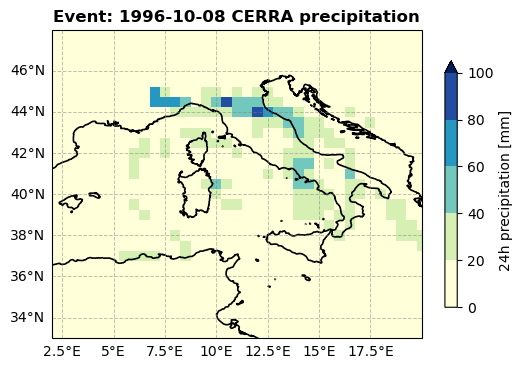

In [54]:
# plot
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 4),
    subplot_kw={'projection': ccrs.PlateCarree()}
    )

# Plot precipitation
fanPM.plot_precipitation(ax, box_event, precip_event_CERRA, 
                         precip_levels=np.arange(0, 110, 20), title=f'Event: {time_ERA5event.strftime("%Y-%m-%d")} CERRA precipitation')

In [55]:
# Threshold: precip > pr_thresh
pr_thresh = 20  # mm/day
mask_pr = precip_event_CERRA > pr_thresh

# Label connected components
structure = np.ones((3,3))  # 8-connectivity
labeled_mask, num_features = ndimage.label(mask_pr, structure=structure)
labeled_mask = labeled_mask.astype(float)
labeled_mask[labeled_mask == 0] = np.nan

/tmp/ipykernel_8568/3371806065.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_features)


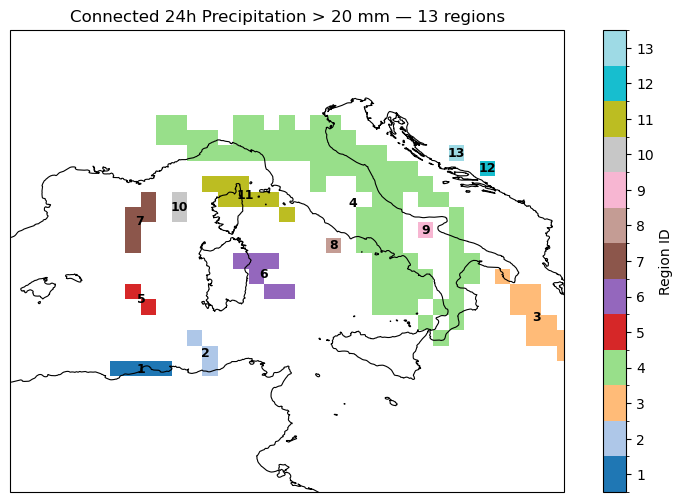

In [56]:
import matplotlib as mpl

fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

# White background everywhere
ax.set_facecolor("white")           # Plot area
fig.patch.set_facecolor("white")    # Figure background

# Coastlines & borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
# ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Data extent
ax.set_extent(box_event, crs=ccrs.PlateCarree())

# Plot mask
cmap = plt.cm.get_cmap('tab20', num_features)
bounds = np.arange(0.5, num_features + 1.5, 1)  # boundaries between IDs
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
im = ax.pcolormesh(precip_event_CERRA.lon, precip_event_CERRA.lat, labeled_mask,
                   cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cb = plt.colorbar(im, ax=ax, ticks=np.arange(1, num_features + 1))
cb.set_label("Region ID")

# Annotate IDs
for region_id in range(1, num_features + 1):
    coords = np.argwhere(labeled_mask == region_id)
    if coords.size > 0:
        lat_mean = precip_event_CERRA.lat.values[coords[:, 0]].mean()
        lon_mean = precip_event_CERRA.lon.values[coords[:, 1]].mean()
        ax.text(lon_mean, lat_mean, str(region_id),
                color="black", ha="center", va="center",
                fontweight="bold", fontsize=9,
                transform=ccrs.PlateCarree())

ax.set_title(f"Connected 24h Precipitation > {pr_thresh} mm — {num_features} regions")
plt.show()
fig.tight_layout()
# # Save the figure
# fig.savefig(fig_dir+'pr-regions_BAM-'+var_analogues+'_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')

In [57]:
### Save mask of most-representative region ID
# Choice of labeled region ID to save
if no_node==1 and no_event==1:
    region_id = 1
elif no_node==6 and no_event==19:
    region_id = 4

# Create a mask where only region_id is kept, others set to 0
region_mask = np.where(labeled_mask == region_id, labeled_mask, 0)
region_mask = region_mask/region_mask.max()

# Convert to a DataArray
region_da = xr.DataArray(region_mask,
                          coords=precip_event_CERRA.coords,
                          dims=precip_event_CERRA.dims,
                          name=f'pr_mask')
region_da.to_netcdf(f'./analogue_data/event_data/pr-mask_node'+str(no_node)+'-extreme'+str(no_event)+'-alertregions_CERRA.nc')

# Compute average precipitation in the region
mean_precip_in_region = precip_event_CERRA.where(region_da==1).mean().item()
print(f"Average precipitation in region ID {region_id}: {mean_precip_in_region} ")

Average precipitation in region ID 4: 36.8004150390625 


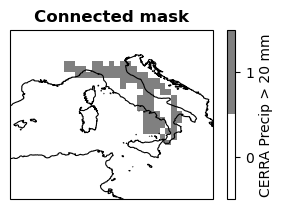

In [58]:
## Plot mask of most-representative region ID
fig, ax = plt.subplots(
    figsize=(3.5, 2.2),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

# White background everywhere
ax.set_facecolor("white")           # Plot area
fig.patch.set_facecolor("white")    # Figure background

# Coastlines & borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Data extent
ax.set_extent(box_event, crs=ccrs.PlateCarree())

# Plot the region where region_da == 1
im = ax.pcolormesh(region_da.lon, region_da.lat, region_da == 1,
                   cmap=mpl.colors.ListedColormap(['white', 'grey']), transform=ccrs.PlateCarree())

# Add a colorbar with centered labels
cb = plt.colorbar(im, ax=ax, ticks=[0.25, 0.75])
cb.ax.set_yticklabels(['0', '1'])
cb.set_label(f"CERRA Precip > {pr_thresh} mm")

ax.set_title("Connected mask", fontsize=12, weight="bold")
plt.show()
fig.tight_layout()
# Save the figure
fig.savefig('./analogue_data/event_data/pr-mask_'+str_event+'_CERRA.png')

In [59]:
# Compute average precip in the selected region amongst the 10 best analogues
# Upload analogue data
list_ds_BAMs = []

# Load analogue regional values
file = f'./analogue_data/analogue_differences/analogues-{var_analogues}_mask-mean-pr_{str_event}_99pct_2004-2023_CRCM5_49membs.nc'
if not os.path.exists(file):
    print(f'File {file} does not exist.')
ds_regional = xr.open_dataset(file)
BAM_mean_precip_in_region = np.array([
    ds_regional.sel(member=list_BAM_members[i]).sel(analogue=ind_extremes[i] + 1)['pr'].values
    for i in range(len(list_BAM_members))
])
print(BAM_mean_precip_in_region*3600)

# Map precip for BAM analogue dates
# precip
precip_files = fanPM.get_precipitation_paths_CRCM5_bymonth(CRCM5_dir, list_BAM_members, [[date] for date in list_BAM_dates_noleap])
# Make list of datasets and add 'member' coordinate
list_ds = fanPM.open_member_datasets(precip_files, combine='by_coords', expand_member_dim=True)
# Order list from alphabetical order of member to order in BAM_members
list_alphabetical_members = list(dict.fromkeys(sorted(list_BAM_members)))
list_ds = [list_ds[list_alphabetical_members.index(member)] for member in list_BAM_members]

# Select lon lat mask for the event
ds_tmp = list_ds[0]
lon_mask, lat_mask = fanPM.lonlat_mask(ds_tmp.lon.values, ds_tmp.lat.values, box_event)
mask_BAM = lat_mask[:, np.newaxis] & lon_mask
mask_xr_BAM = xr.DataArray(
    mask_BAM,
    dims=["lat", "lon"],
    coords={"lat": ds_tmp.lat.values, "lon": ds_tmp.lon.values},
)

# scale, choose date and select box
list_pr_BAM = []
for i, ds in enumerate(list_ds):
    pr_tmp = ds['pr'] * 3600 # Convert from mm/s*24 to mm/day
    pr_tmp = pr_tmp.sel(time=list_BAM_dates_noleap[i] + timedelta(hours=12))
    pr_tmp = pr_tmp.where(mask_xr_BAM, drop=True)
    list_pr_BAM.append(pr_tmp.squeeze())


[16.3679351  12.87795534 12.3379711  11.73335268 12.50269575  1.39030291
  7.60397225  5.20455214 13.19004244 20.49881168]
Opening files for member: kbe
Opening files for member: kbf
Opening files for member: kbg
Opening files for member: kbh
Opening files for member: kbm
Opening files for member: kbn
Opening files for member: kbx
Opening files for member: kby
Opening files for member: kcb
Opening files for member: kcd


### Plot precip in N_BAM BAMs

8.134213
28.56481
14.644437
11.821238
26.66224
9.613841
7.3152156
15.285395
19.705105
18.623892


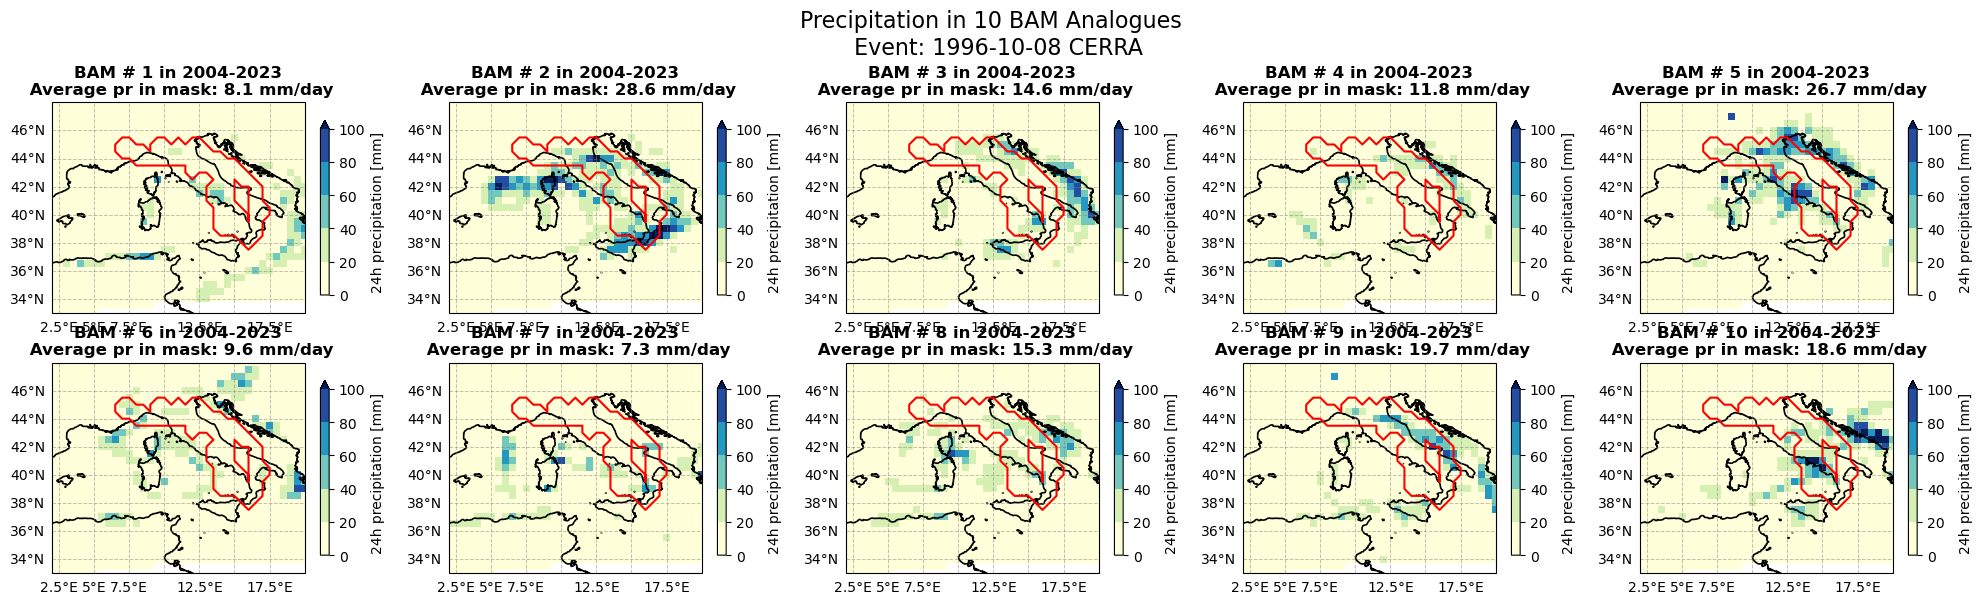

In [60]:
fig, ax = plt.subplots(
    nrows=2, ncols=5, figsize=(4*5, 3*2),
    sharey=True,
    subplot_kw={'projection': ccrs.PlateCarree()}
    )
ax = ax.ravel()

# Plot
for i in range(N_BAM):
    # mean precip in region
    pr_region = np.nanmean(list_pr_BAM[i].where(region_da==1))
    print(pr_region)
    pr_time = list_BAM_dates_noleap[i] + timedelta(hours=12)
    fanPM.plot_precipitation(
        ax[i], 
        box_event, 
        list_pr_BAM[i], 
        np.arange(0, 110, 20),
        f'BAM # {i+1} in 2004-2023\n Average pr in mask: {pr_region:.1f} mm/day')
    # hatch region mask
    ax[i].contour(
        region_da.lon, region_da.lat, region_da, 
        levels=[0], colors='red', linewidths=1.5, transform=ccrs.PlateCarree()
    )
    
fig.suptitle(f'Precipitation in 10 BAM Analogues \n Event: {time_ERA5event.strftime("%Y-%m-%d")} CERRA', fontsize=16)
fig.tight_layout()
fig.savefig(fig_dir+'pr_10BAMs_'+str_event+'_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')
